## A model is defined in six steps:
1. Initialise model
2. Define parameters and variables
3. State governing equations
4. State boundary conditions
5. State initial conditions
6. State output variables

In [63]:
import os
import numpy as np
import pybamm
import matplotlib.pyplot as plt

### Initialise model

In [64]:
model = pybamm.BaseModel() # BaseModel: empty model for customization

### Define parameters and variables

In [65]:
# Parameters: fixed inputs (the solver does not evolve)
k_ref = pybamm.Parameter("Reaction rate constant [m.s-1]")
E_a = pybamm.Parameter("SEI growth activation energy [J.mol-1]")
T_ref = pybamm.Parameter("Reference temperature [K]")
T_amb = pybamm.Parameter("Ambient temperature [K]")
C_th = pybamm.Parameter("Thermal capacity [J.K-1]")
R_th = pybamm.Parameter("Thermal resistance [K.W-1]")
R_ohm = pybamm.Parameter("Ohmic resistance [Ohm]")
V_hat = pybamm.Parameter("Partial molar volume [m3.mol-1]")


# FunctionParameter: define parameters which are functions of other variables
# Diffusivity is defined as a function of solvent concentration

def I_app(t):
    return pybamm.FunctionParameter("Applied current [A]", {"Time [s]": t})

def D(xx):
    return pybamm.FunctionParameter(
        "Diffusivity [m2.s-1]", {"Solvent concentration [mol.m-3]": xx}
    )



In [66]:
# Define variables (the model solves for as functions of time/space)
xi = pybamm.SpatialVariable("xi", domain="SEI layer", coord_sys="cartesian")
c = pybamm.Variable("Solvent concentration [mol.m-3]", domain="SEI layer")
L = pybamm.Variable("SEI thickness [m]")
T = pybamm.Variable("Cell temperature [K]")
I_1C = pybamm.Parameter("1C current [A]")
I_period = pybamm.Parameter("Current period [s]")
k = pybamm.Parameter("Reaction rate constant [m.s-1]")
L_0 = pybamm.Parameter("Initial thickness [m]")
V_hat = pybamm.Parameter("Partial molar volume [m3.mol-1]")
c_inf = pybamm.Parameter("Bulk electrolyte solvent concentration [mol.m-3]")


### State governing equations

In [86]:
I_1C = 50.0  # A, for 50 Ah cell

t_charge = 3600.0
t_rest = 1800.0
t_discharge = 3600.0
t_rest2 = 1800.0

cycle_time = t_charge + t_rest + t_discharge + t_rest2
n_cycles = 10
t_end = n_cycles * cycle_time

dt = 10.0  # time resolution for the current profile (s)
t_profile = np.arange(0, t_end + dt, dt)

tau = t_profile % cycle_time
I_profile = np.where(
    tau < t_charge, I_1C,
    np.where(
        tau < t_charge + t_rest, 0.0,
        np.where(
            tau < t_charge + t_rest + t_discharge, -I_1C, 0.0
        )
    )
)


In [87]:
# 1C/1C square-wave current profile (symbolic)
I = pybamm.Interpolant(t_profile, I_profile, pybamm.t)

# Temperature-dependent reaction rate (Arrhenius)
k_T = k_ref * pybamm.exp(-E_a / pybamm.constants.R * (1 / T - 1 / T_ref))

# SEI reaction flux (restricted by temperature)
R = k_T * pybamm.BoundaryValue(c, "left")

# Solvent concentration equation
N = -1 / L * D(c) * pybamm.grad(c)
dcdt = (V_hat * R) / L * pybamm.inner(xi, pybamm.grad(c)) - 1 / L * pybamm.div(N)

# SEI thickness equation
dLdt = V_hat * R

# Lumped thermal model (ohmic heating + cooling)
dTdt = (I**2 * R_ohm - (T - T_amb) / R_th) / C_th


Once we have stated the equations, we can add them to the `model.rhs` dictionary. This is a dictionary whose keys are the variables being solved for, and whose values correspond right hand sides of the governing equations for each variable.

In [88]:
# Attach previously defined time derivatives to state variables
model.rhs = {c: dcdt, L: dLdt, T: dTdt}


### State boundary conditions

In [89]:
# Set boundary conditions on negative–SEI interface (left)
D_left = pybamm.BoundaryValue(
    D(c), "left"
)  # pybamm requires BoundaryValue(D(c)) and not D(BoundaryValue(c))
grad_c_left = R * L / D_left

In [90]:
# Set boundary conditions on SEI–electrolyte interface (right)
c_right = c_inf

In [91]:
# Load boundary conditions into the model
# Neumann: on the gradient
# Dirichlet: on the variable itself
model.boundary_conditions = {
    c: {"left": (grad_c_left, "Neumann"), "right": (c_right, "Dirichlet")}
}

### State initial conditions

In [92]:
# Set initial electrolyte concentration, SEI thickness, and temperature
c_init = c_inf
L_init = L_0
T_init = T_amb


In [93]:
# Load initial conditions into the model
model.initial_conditions = {c: c_init, L: L_init, T: T_init}


### State output variables

In [94]:
# Define model variables to be reported
model.variables = {
    "SEI thickness [m]": L,
    "SEI growth rate [m]": dLdt,
    "Solvent concentration [mol.m-3]": c,
    "Cell temperature [K]": T,
    "Applied current [A]": I,
}


## Applying the Model

In [100]:
# Define geometry: 1D domain "SEI layer" w/ coordinate xi = [0, 1]
geometry = pybamm.Geometry(
    {"SEI layer": {xi: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}
)

# Diffusivity function for the parameter set

def Diffusivity(xx):
    return xx * 10 ** (-12)

# Parameter values
param = pybamm.ParameterValues(
    {
        "Reaction rate constant [m.s-1]": 1e-6,
        "SEI growth activation energy [J.mol-1]": 3.5e4,
        "Reference temperature [K]": 298.15,
        "Initial thickness [m]": 1e-6,
        "Partial molar volume [m3.mol-1]": 10,
        "Bulk electrolyte solvent concentration [mol.m-3]": 1,
        "Ambient temperature [K]": 298.15,
        "Thermal capacity [J.K-1]": 500.0,
        "Thermal resistance [K.W-1]": 1.0,
        "Ohmic resistance [Ohm]": 0.05,
        "1C current [A]": 50.0,
        "Current period [s]": 7200.0,
        "Diffusivity [m2.s-1]": Diffusivity,
    }
)

# Process model and geometry
param.process_model(model)
param.process_geometry(geometry)

# Mesh and discretise
submesh_types = {"SEI layer": pybamm.Uniform1DSubMesh}
var_pts = {xi: 1000}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"SEI layer": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc_model = disc.process_model(model, inplace=False)


In [101]:
# solve
solver = pybamm.ScipySolver()
t = [0, t_profile]  # solve for 100s
solution = solver.solve(disc_model, t_profile)

# Post-process output variables
t = solution.t
L_out = solution["SEI thickness [m]"]
c_out = solution["Solvent concentration [mol.m-3]"]
T_out = solution["Cell temperature [K]"]
R_out = solution["SEI growth rate [m]"]



Using these outputs, we can now plot the SEI thickness as a function of time and also the solvent concentration profile within the SEI. We use a slider to plot the concentration profile at different times. Note that, even though our model is written in nondimensional form, the processed variables are functions of dimensional space and time (in SI units). 

In [102]:
# plot SEI thickness in microns as a function of t in microseconds
# and concentration in mol/m3 as a function of x in microns
L_0_eval = param.evaluate(L_0)
xi_vals = np.linspace(0, 1, 100)  # dimensionless space


def plot(t):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(solution.t, L_out(solution.t) * 1e6)
    ax1.plot(t, L_out(t) * 1e6, "r.")
    ax1.set_ylabel(r"SEI thickness [$\mu$m]")
    ax1.set_xlabel(r"t [s]")

    ax2.plot(xi_vals * L_out(t) * 1e6, c_out(t, xi_vals))
    ax2.set_ylim(0, 1.1)
    ax2.set_xlim(0, L_out(solution.t[-1]) * 1e6)
    ax2.set_ylabel("Electrolyte solvent concentration [mol.m-3]")
    ax2.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout()
    plt.show()


import ipywidgets as widgets

widgets.interact(
    plot, t=widgets.FloatSlider(min=0, max=solution.t[-1], step=0.1, value=0)
);

interactive(children=(FloatSlider(value=0.0, description='t', max=108000.0), Output()), _dom_classes=('widget-…

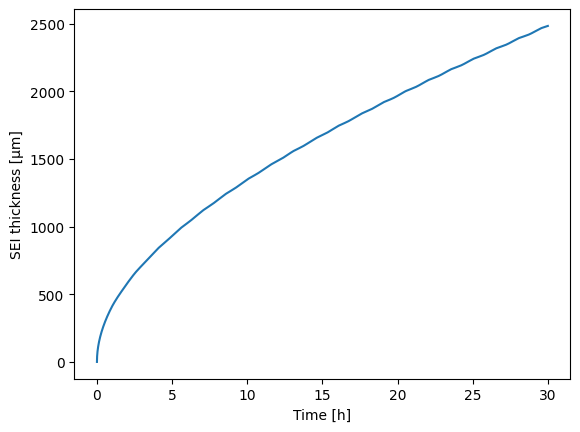

In [105]:
plt.plot(solution.t/3600, L_out(solution.t) * 1e6)
plt.xlabel("Time [h]")
plt.ylabel("SEI thickness [μm]")
plt.show()


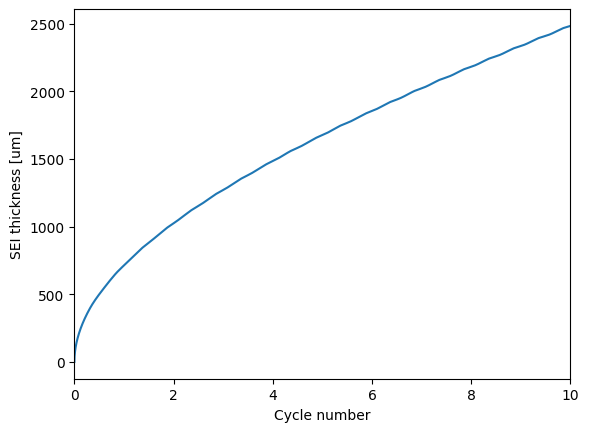

In [107]:
cycle_time = t_charge + t_rest + t_discharge + t_rest2  # seconds per cycle
cycles = solution.t / cycle_time

plt.plot(cycles, L_out(solution.t) * 1e6)
plt.xlabel("Cycle number")
plt.ylabel("SEI thickness [um]")
plt.xlim(0, n_cycles)
plt.show()


## References

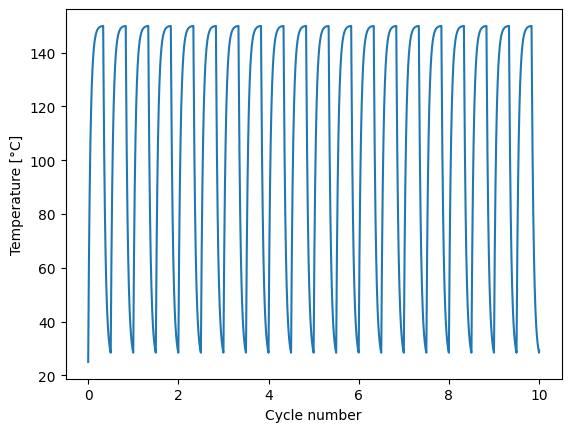

In [110]:
plt.plot(cycles, T_out(solution.t) - 273.15)
plt.xlabel("Cycle number")
plt.ylabel("Temperature [°C]")
plt.show()


In [79]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). Journal of Open Research Software, 9(1):14, 2021. doi:10.5334/jors.309.
[4] Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, and others. SciPy 1.0: fundamental algorithms for scientific computing in Python. Na